In [1]:
import pandas_datareader as web
import datetime as dt

company = 'FB'

start = dt.datetime(2000, 1, 1)
end = dt.datetime(2021, 6, 20)

data = web.DataReader(company, 'yahoo', start, end)

In [2]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999


In [3]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

data['id'] = range(1, len(data) + 1)
data['Date'] = data.index.values

data.drop('Volume', axis=1, inplace=True)
data.drop('Adj Close', axis=1, inplace=True)

scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

scaled_data = pd.DataFrame(scaled_data)

scaled_data['id'] = range(1, len(scaled_data) + 1)

scaled_data = scaled_data.rename(columns={0: 'Scaled_data'})

data = pd.merge(data, pd.DataFrame(scaled_data), on='id', how='left').drop('id', axis=1)

In [4]:
data.head()

,High,Low,Open,Close,Date,Scaled_data
0,45.000000,38.000000,42.049999,38.230000,2012-05-18,0.064255
1,36.660000,33.000000,36.529999,34.029999,2012-05-21,0.051091
2,33.590000,30.940001,32.610001,31.000000,2012-05-22,0.041594
3,32.500000,31.360001,31.370001,32.000000,2012-05-23,0.044728
4,33.209999,31.770000,32.950001,33.029999,2012-05-24,0.047956


In [5]:
def winter(x):
  month = str(x).split('-')[1]
  if month in ['12', '01', '02']:
    return 1
  else:
    return 0

def spring(x):
  month = str(x).split('-')[1]
  if month in ['03', '04', '05']:
    return 1
  else:
    return 0

def summer(x):
  month = str(x).split('-')[1]
  if month in ['06', '07', '08']:
    return 1
  else:
    return 0

def autumn(x):
  month = str(x).split('-')[1]
  if month in ['09', '10', '11']:
    return 1
  else:
    return 0

data['Year_price'] = data['Close'].shift(-365)
data['Winter'] = data['Date'].apply(lambda x: winter(x))
data['Spring'] = data['Date'].apply(lambda x: spring(x))
data['Summer'] = data['Date'].apply(lambda x: summer(x))
data['Autumn'] = data['Date'].apply(lambda x: autumn(x))

data.drop('Date', axis=1, inplace=True)

autoreg_columns = ['Year_price']

for i in range(1, 16):
  data['Price_LD_{}'.format(i)] = data['Close'].shift(-i)
  autoreg_columns.append('Price_LD_{}'.format(i))

data['moving_mean_all_autoreg'] = data[autoreg_columns].mean(axis=1)
data['moving_std_all_autoreg'] = data[autoreg_columns].std(axis=1)
data['moving_var_all_autoreg'] = data[autoreg_columns].var(axis=1)
data['moving_min_all_autoreg'] = data[autoreg_columns].min(axis=1)
data['moving_max_all_autoreg'] = data[autoreg_columns].max(axis=1)

data['target'] = data['Close'].shift(-1)

data.dropna(inplace=True)

In [6]:
data.head()

,High,Low,Open,Close,Scaled_data,Year_price,Winter,Spring,Summer,Autumn,Price_LD_1,Price_LD_2,Price_LD_3,Price_LD_4,Price_LD_5,Price_LD_6,Price_LD_7,Price_LD_8,Price_LD_9,Price_LD_10,Price_LD_11,Price_LD_12,Price_LD_13,Price_LD_14,Price_LD_15,moving_mean_all_autoreg,moving_std_all_autoreg,moving_var_all_autoreg,moving_min_all_autoreg,moving_max_all_autoreg,target
0,45.000000,38.000000,42.049999,38.230000,0.064255,50.209999,0,1,0,0,34.029999,31.000000,32.000000,33.029999,31.910000,28.840000,28.190001,29.600000,27.719999,26.900000,25.870001,26.809999,26.309999,27.100000,27.010000,30.408125,5.874454,34.509213,25.870001,50.209999,34.029999
1,36.660000,33.000000,36.529999,34.029999,0.051091,49.750000,0,1,0,0,31.000000,32.000000,33.029999,31.910000,28.840000,28.190001,29.600000,27.719999,26.900000,25.870001,26.809999,26.309999,27.100000,27.010000,27.400000,29.965000,5.729579,32.828080,25.870001,49.750000,31.000000
2,33.590000,30.940001,32.610001,31.000000,0.041594,48.220001,0,1,0,0,32.000000,33.029999,31.910000,28.840000,28.190001,29.600000,27.719999,26.900000,25.870001,26.809999,26.309999,27.100000,27.010000,27.400000,27.270000,29.636250,5.407912,29.245507,25.870001,48.220001,32.000000
3,32.500000,31.360001,31.370001,32.000000,0.044728,50.110001,0,1,0,0,33.029999,31.910000,28.840000,28.190001,29.600000,27.719999,26.900000,25.870001,26.809999,26.309999,27.100000,27.010000,27.400000,27.270000,28.290001,29.522500,5.822481,33.901288,25.870001,50.110001,33.029999
4,33.209999,31.770000,32.950001,33.029999,0.047956,49.119999,0,1,0,0,31.910000,28.840000,28.190001,29.600000,27.719999,26.900000,25.870001,26.809999,26.309999,27.100000,27.010000,27.400000,27.270000,28.290001,30.010000,29.271875,5.511601,30.377747,25.870001,49.119999,31.910000


In [7]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'])

print(f'Train shape: {X_train.shape[0]}')
print(f'Test shape: {X_test.shape[0]}')

X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)

Train shape: 1440
Test shape: 481


In [22]:
from numba import jit
import math


def smape(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

In [9]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [47]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

with strategy.scope():
    model = Sequential(
        [
        layers.Dense(16, activation='relu', input_shape=(X_train.shape[1:])),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(64),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='elu'),
        layers.Dense(1)
        ]
    )

    model.compile(
        optimizer='adam', loss='mean_squared_error'
    )

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 1, 16)             496       
_________________________________________________________________
lstm_30 (LSTM)               (None, 1, 64)             20736     
_________________________________________________________________
dropout_30 (Dropout)         (None, 1, 64)             0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 1, 64)             33024     
_________________________________________________________________
dropout_31 (Dropout)         (None, 1, 64)             0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)              

In [48]:
epochs = 50
batch_size = 32

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/50
45/45 [==============================] - 9s 60ms/step - loss: 14979.0303 - val_loss: 14148.4746
Epoch 2/50
45/45 [==============================] - 0s 8ms/step - loss: 12982.6113 - val_loss: 11557.9707
Epoch 3/50
45/45 [==============================] - 0s 9ms/step - loss: 10021.4238 - val_loss: 8196.3359
Epoch 4/50
45/45 [==============================] - 0s 9ms/step - loss: 6599.3203 - val_loss: 5009.0239
Epoch 5/50
45/45 [==============================] - 0s 9ms/step - loss: 4166.4048 - val_loss: 3491.7886
Epoch 6/50
45/45 [==============================] - 0s 9ms/step - loss: 3412.4912 - val_loss: 3240.9187
Epoch 7/50
45/45 [==============================] - 0s 9ms/step - loss: 2201.6050 - val_loss: 1562.1992
Epoch 8/50
45/45 [==============================] - 0s 9ms/step - loss: 1421.8403 - val_loss: 670.2731
Epoch 9/50
45/45 [==============================] - 0s 10ms/step - loss: 878.5740 - val_loss: 381.6454
Epoch 10/50
45/45 [==============================] - 0s 8ms/

In [50]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

preds = model.predict(X_test).flatten()

smape(y_test, preds)

6.966090493791506

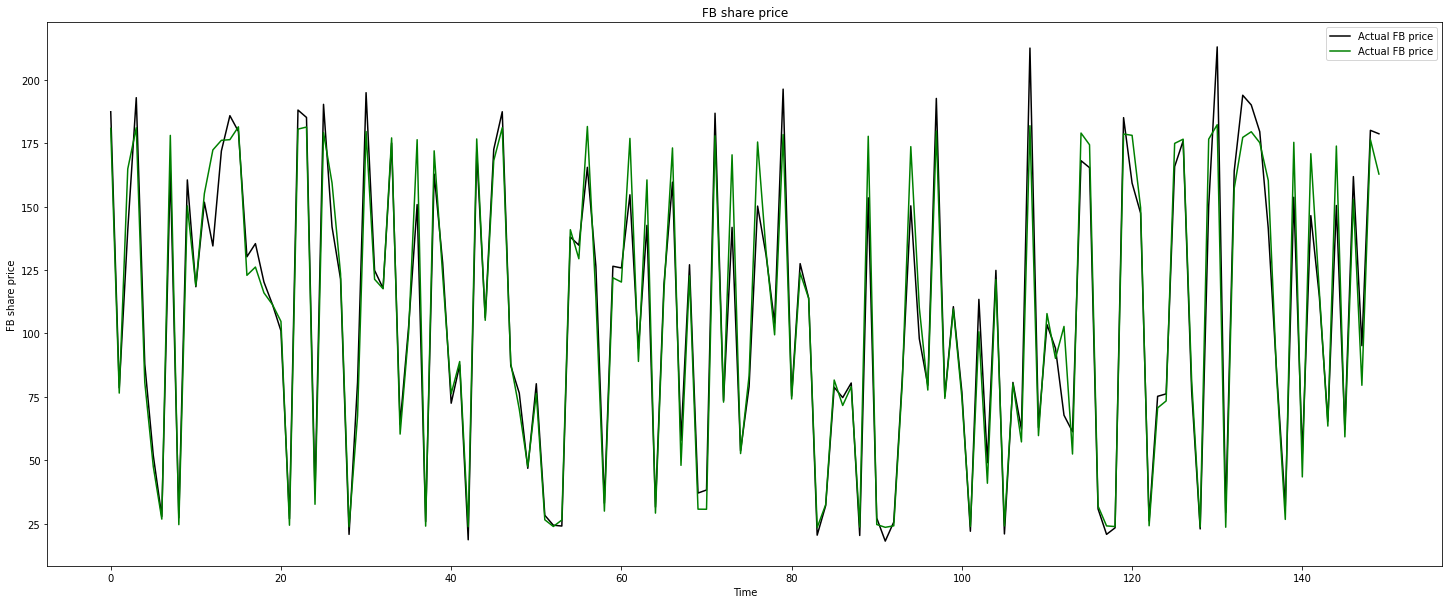

In [71]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25,10))
plt.plot(range(len(y_test[:150])), y_test[:150], color='black', label=f'Actual {company} price')
plt.plot(range(len(preds[:150])), preds[:150], color='green', label=f'Actual {company} price')
plt.title(f'{company} share price')
plt.xlabel('Time')
plt.ylabel(f'{company} share price')
plt.legend()
plt.show()